# **<span style="color:black;">Imputing Encoding and Heatmaps</span>**

## **Purpose of Notebook**
Loading the cleaned Dataset, Encoding and Scaling Functions, Imputing missing values, Correlation Heatmap

---

## **Contents of notebook**
### **Section 1: Loading and Merging Dataset**
```python 
- [x] Loading the cleaned datasets
- [x] Splitting Columns into Datatypes
```
### **Section 2: Assessing Missing Values**
```python 
- [x] Displaying Missing Percentage per column 
- [x] Dropping Values with less than 5%
- [x] Defining which columns to impute
- [x] Converting Numerical Speed Limit into bins of 10s
```
### **Section 3: Imputing Methods**
```python 
- [x] Mode Imputation
- [x] LOCF Imputation
- [x] Random Forest Imputation
- [x] XGBoost Imputation
- [x] Jaccard Score and Accuracy
- [x] Evaluate all the imputation and choose best method
- [x] Impute Using Best Method
```
### **Section 4: Encoding and Scaling**
```python 
- [x] Encode the columns (scaling not needed as no numerical)
```
### **Section 5: Heatmap**
### **Section 6: Save File**
```python 
- [x] US Imputed
- [x] Encoded df saved
```

**Import Necessary Libraries and Modules**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from tabulate import tabulate
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, mean_squared_error,
    silhouette_score, jaccard_score
)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor


## **<span style="color:black;">Section 1: Loading Datasets and General Check</span>**

**Loading Cleaned Datasets**

In [2]:
# Display all columns of a pandas DataFrame when printed
pd.set_option('display.max_columns', None)

# US Dataset
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US-cleaned_data.csv')
# UK Dataset
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')
UK_data = UK_data.drop(['latitude', 'longitude'], axis=1)

print("US Dataset Shape:", US_data.shape)
print("UK Dataset Shape:", UK_data.shape)

US Dataset Shape: (4353, 21)
UK Dataset Shape: (229782, 23)


**Splitting Columns into Datatypes**

In [3]:
# Identify numerical and categorical columns
# treating speed limit as categorical numerical_columns 
categorical_columns = ['Posted Speed Limit (MPH)'
    'Make', 'Model', 'ADS Equipped?','Model Year'
    'Automation System Engaged?', 'City', 'State', 'Roadway Type', 'Roadway Surface',
    'Lighting', 'Crash With', 'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement', 'SV Contact Area', 'Weather', 'Country']
datetime_columns = ['Incident Date','Incident Time (24:00)']
indexing_columns = ['Report ID', 'Report Version']

## **<span style="color:black;">Section 2: Assessing Missing Values</span>**

**How much missing Data**
- if we drop the values recorded by the organisation as unknown we will get less than 1800 rows from the original 4000 size
- recording unknown and being missing is 2 different things
- imputing could add a lot of errors possibly 
- unknown can be handled by some models and is there a reason why it is even unknown in the first place? 
- if high accuracy imputing when we could use that method or treat unknown as it's own catergory

In [4]:
def display_missing_and_unknown_separate(dataset, dataset_name):
    """
    Purpose: 
    Reference:
    """
    # Columns that have missing or unknown values
    features_with_issues = [
        col for col in dataset.columns
        if dataset[col].isnull().sum() > 0 

    ]
    
    table = PrettyTable()
    table.field_names = ["Feature", "Percentage Missing"]
    
    for col in features_with_issues:
        missing_pct = np.round(dataset[col].isnull().mean() * 100, 2)
        table.add_row([col, f"{missing_pct} %"])
    
    print(f"Missing' Values in {dataset_name}:")
    print(table)

# Usage:
display_missing_and_unknown_separate(UK_data, "UK Dataset")
display_missing_and_unknown_separate(US_data, "US Dataset")

Missing' Values in UK Dataset:
+---------+--------------------+
| Feature | Percentage Missing |
+---------+--------------------+
+---------+--------------------+
Missing' Values in US Dataset:
+---------------------------------+--------------------+
|             Feature             | Percentage Missing |
+---------------------------------+--------------------+
|               Make              |       0.02 %       |
|              Model              |       0.05 %       |
|            Model Year           |       0.3 %        |
|    Automation System Engaged?   |       4.99 %       |
|      Incident Time (24:00)      |       4.18 %       |
|               City              |       1.7 %        |
|           Roadway Type          |       13.6 %       |
|         Roadway Surface         |      19.16 %       |
|     Posted Speed Limit (MPH)    |      10.98 %       |
|             Lighting            |      19.32 %       |
|            Crash With           |      20.93 %       |
| Highes

**Drop the Rows for which less than 5% of column data is missing**

In [5]:
# Drop rows with NaN values in the specified columns
cols_to_check = ['Make', 'Model', 'Model Year', 'Automation System Engaged?', 'Incident Time (24:00)', 'City']
US_data = US_data.dropna(subset=cols_to_check)

# Display the new shape
print("Shape after dropping rows with NaNs in specified columns:", US_data.shape)
US_data.head()

Shape after dropping rows with NaNs in specified columns: (4032, 21)


,Report ID,Report Version,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Lighting,Crash With,Highest Injury Severity Alleged,SV Pre-Crash Movement,Weather,SV Contact Area,Country
6,10039-10316,4,BMW,XM,2023.0,No,ADAS,2025-03-25,14:06:00,Benton County,AR,Highway / Freeway,NaN,65.0,NaN,First Responder Vehicle,Minor,NaN,NaN,"Back, Front",US
9,10039-3997,3,BMW,X5 sDrive40i,2020.0,No,ADAS,2025-05-22,22:25:00,Refugio,TX,Highway / Freeway,NaN,75.0,NaN,Pole / Tree,Serious,Proceeding Straight,Clear,Front,US
10,10039-4636,4,BMW,X5,2022.0,No,ADAS,2025-12-22,07:05:00,Fairfield,CA,Highway / Freeway,NaN,NaN,NaN,Other Fixed Object,Minor,Lane / Road Departure,NaN,Front,US
15,10039-6833,4,BMW,iX xDrive50,2023.0,No,ADAS,2025-12-23,06:00:00,Bel Air,MD,Highway / Freeway,NaN,NaN,"Other, see Narrative",Other Fixed Object,No Injuries Reported,Proceeding Straight,Fog/Smoke,"Back, Front, Nearside",US
17,10039-8,3,BMW,X5 xDrive40i,2019.0,No,ADAS,2025-07-21,03:01:00,Miami,FL,Highway / Freeway,NaN,NaN,"Other, see Narrative","Other, see Narrative",Minor,Changing Lanes,Other,"Back, Front, Offside",US


**Remaining Columns to Impute**

In [6]:
cols_to_impute = [
     'Roadway Type', 'Roadway Surface', 
    'Posted Speed Limit (MPH)', 'Lighting', 'Crash With', 
    'Highest Injury Severity Alleged', 'SV Pre-Crash Movement', 'Weather', 
    'SV Contact Area'
]


**Converting Posted Speed Limit to Catergorical**
- want to see the 10s (60s, 30s, 20s etc) it is in instead of a mean of 37.5 
- no need to encode beforehand 
- incident time is treated as numerical

In [7]:
# Round to the nearest multiple of 10 
US_data['Posted Speed Limit (MPH) Rounded'] = US_data['Posted Speed Limit (MPH)'].apply(
    lambda x: 10 * round(x / 10) if pd.notnull(x) else np.nan
)

# Convert to categorical with string labels, keeping NaN as NaN
US_data['Posted Speed Limit (MPH)'] = US_data['Posted Speed Limit (MPH) Rounded'].apply(
    lambda x: str(int(x)) if pd.notnull(x) else np.nan
)

US_data['Posted Speed Limit (MPH)'] = US_data['Posted Speed Limit (MPH)'].astype('category')
US_data.drop(columns=['Posted Speed Limit (MPH) Rounded'], inplace=True)

# Check the results
print("Speed limit categories after processing:")
print(US_data['Posted Speed Limit (MPH)'].value_counts().sort_index())

Speed limit categories after processing:
Posted Speed Limit (MPH)
0       17
10       7
20    1189
30     231
40     812
50      96
60    1102
70     233
80      76
Name: count, dtype: int64


## **<span style="color:black;">Section 3: Imputation Method</span>**

**Mode Imputation**
- Simple and fast method to use the most common catergory or mean of numerical columns

In [8]:
def mode_impute(df, columns):
    """
    Process: Simple mode imputation for categorical columns only
    Reference: how to replace value with mode in the df https://stackoverflow.com/questions/66565971/how-to-impute-entire-missing-values-in-pandas-dataframe-with-mode-mean
    """
    df_imputed = df.copy() # copy because dont want actual df to change
    for col in columns: # for each column
        if df[col].notna().sum() > 0:  # Only if there are non-null values
            mode_val = df[col].mode() # get mode
            if len(mode_val) > 0: # esnure atleast 1 value to get mode
                df_imputed[col] = df[col].fillna(mode_val[0])
    return df_imputed

**Last Observation Carried Forward Imputation**
- uses incident date to use the last occured instance's value forward

In [9]:
def locf_impute(df, columns):
    """
    Purpose: Last Occurrence Carried Forward imputation algorithim
    Reference: how to get the previous value https://navinniish001.medium.com/pandas-bfill-and-ffill-b79e46ab87ae
    """
    df_imputed = df.copy() # same as mode justuse bfill and ffill
    for col in columns:
        df_imputed[col] = df[col].ffill()  # Forward fill
        # If still NaN after forward fill, use backward fill if front doesnt have value
        df_imputed[col] = df_imputed[col].bfill()
    return df_imputed


**Random Forest Imputation**
- predicts missing value using supervised learning 
- encoded data using one-hot encoder
 regressor for numerical 
 classfier for categorical

In [10]:
# Random Forest imputation
def rf_impute(df, columns, multi_label_cols=None):
    """
    Process: Random Forest imputation for numeric, categorical, and multi-label categorical data
    References:
    - multi value cells: https://stackoverflow.com/questions/49757970/python-pandas-extracting-multi-value-attributes
    - one hot encoded: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
    - random forest basics:https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/
    - rf classifier:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    - rf regressor: https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/
    
    """
    df_imputed = df.copy() # create copy
    multi_label_cols = multi_label_cols or [] # handling SV Contact area as not atomic

    for col in columns: # for each column
        if df[col].isna().sum() == 0: # skip if there is no empty values for col
            continue
        # dealing with multi value non atomic cells
        if col in multi_label_cols: 
            # Multi-label handling (simplified for this example)
            # Convert to most common category for simplicity
            mode_val = df[col].mode()
            if len(mode_val) > 0:
                df_imputed[col] = df[col].fillna(mode_val[0])
        else:
            # Random Forest imputation
            complete_cases = df.dropna(subset=[col]) # completed data where no cells missing
            missing_mask = df[col].isna() # mask for where col is missing
            
            # until no missing values left
            if complete_cases.empty or missing_mask.sum() == 0:
                continue
                
            # Use numerical and categorical features for prediction
            feature_cols = [c for c in df.columns if c != col and df[c].notna().sum() > 0]
            
            if not feature_cols:
                # Fallback to mode if no features available in completed case
                mode_val = df[col].mode()
                if len(mode_val) > 0:
                    df_imputed[col] = df[col].fillna(mode_val[0])
                continue
            
            try:
                # Prepare features ONE-HOT ENCODING
                X_complete = pd.get_dummies(complete_cases[feature_cols], drop_first=True)
                X_missing = pd.get_dummies(df.loc[missing_mask, feature_cols], drop_first=True)
                
                # Align columns to match column order of complete columns
                X_missing = X_missing.reindex(columns=X_complete.columns, fill_value=0)
                
                # Choose model based on data type
                is_numerical = pd.api.types.is_numeric_dtype(df[col])
                
                # regressor for numerical 
                if is_numerical:
                    y = complete_cases[col].values
                    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=1)
                    model.fit(X_complete, y)
                    if not X_missing.empty:
                        preds = model.predict(X_missing)
                        df_imputed.loc[missing_mask, col] = preds
                else: # classifier for categorical
                    y = complete_cases[col].astype(str)
                    if len(y.unique()) > 1:  # Only if multiple categories
                        le = LabelEncoder()
                        y_encoded = le.fit_transform(y)
                        model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=1)
                        model.fit(X_complete, y_encoded)
                        if not X_missing.empty:
                            preds = model.predict(X_missing)
                            preds_decoded = le.inverse_transform(preds)
                            df_imputed.loc[missing_mask, col] = preds_decoded
             # catch error if fails           
            except Exception as e: # catch error for each column
                print(f"    RF failed for {col}")

    return df_imputed


**XGBoost Imputation**
- predicts missing value using supervised learning 
- encoded data using label encoder
- regressor for numerical 
- classfier for categorical

In [11]:
# XGBoost imputation
def xgboost_impute(df, target_col, feature_cols=None):
    """
    Process: XGBoost imputation for a single column
    
    """
    df_imputed = df.copy() # create copy
    if df[target_col].isna().sum() == 0: # make sure there is missing values
        return df_imputed
    if feature_cols is None: # use columns with nans
        feature_cols = [c for c in df.columns if c != target_col and df[c].notna().sum() > 0]

    try: # mask creation with mssing and completed list
        complete_mask = df[target_col].notna()
        missing_mask = df[target_col].isna()
        
        if complete_mask.sum() == 0 or missing_mask.sum() == 0:
            return df_imputed
        
        # Prepare data 
        X_train = pd.get_dummies(df.loc[complete_mask, feature_cols], drop_first=True)
        X_missing = pd.get_dummies(df.loc[missing_mask, feature_cols], drop_first=True)
        
        # Align columns with the completed
        X_missing = X_missing.reindex(columns=X_train.columns, fill_value=0)
        
        # Clean column names for XGBoost
        X_train.columns = [str(c).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for c in X_train.columns]
        X_missing.columns = X_train.columns
        
        # if any numerical values then check the datatype and use regressior instead
        is_numerical = pd.api.types.is_numeric_dtype(df[target_col])
        if is_numerical: # code for regressor
            y_train = df.loc[complete_mask, target_col].values
            model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
            model.fit(X_train, y_train)
            if not X_missing.empty:
                preds = model.predict(X_missing)
                df_imputed.loc[missing_mask, target_col] = preds
        
        # if column is categorical then use classifier and label encode
        else:
            y_train = df.loc[complete_mask, target_col].astype(str)
            if len(y_train.unique()) > 1:
                le = LabelEncoder()
                y_encoded = le.fit_transform(y_train)
                model = xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0, eval_metric='logloss')
                model.fit(X_train, y_encoded)
                if not X_missing.empty:
                    preds = model.predict(X_missing)
                    preds_decoded = le.inverse_transform(preds)
                    df_imputed.loc[missing_mask, target_col] = preds_decoded
            else: # if only 1 class then use mode
                df_imputed.loc[missing_mask, target_col] = y_train.iloc[0]
                
    except Exception as e: # catch error if doesnt work
        print(f"    XGBoost failed for {target_col}")
    return df_imputed


**Calculate Jaccard Index**
- Compute the sample wise jaccard as it for multi-label/value the accuracy will be lower if values not in the exact order.
- Jaccard score doesnt care about the order it just ensures the values are there as it compares the intersection of sets

In [12]:
# Jaccard score calculation
def calculate_jaccard_score(y_true, y_pred, multi_label=False):
    """
    Process: Calculate Jaccard score for single-label or multi-label data hence order of data within cell doesnt matter
    Reference: 
    - stipping mutli-value cells: https://stackoverflow.com/questions/11001247/fastest-way-to-split-a-concatenated-string-into-a-tuple-and-ignore-empty-strings
    - creating sets:  https://www.w3schools.com/python/python_sets.asp
    - jaccard score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
    - macro and binary jaccard cases help: https://www.geeksforgeeks.org/data-science/how-to-calculate-jaccard-similarity-in-python/
    """
    try: # For multi-label, convert strings to sets and calculate Jaccard   
        if multi_label:
            def string_to_set(s):
                """
                Process: Convert the CSV values into stripped labels if not empty
                """
                if pd.isna(s) or s == '': 
                    return set()
                return set([x.strip() for x in str(s).split(',') if x.strip()])
            # convert into sets
            true_sets = [string_to_set(x) for x in y_true]
            pred_sets = [string_to_set(x) for x in y_pred]
            
            jaccard_scores = [] # store the results in this list
            # loop through the sets using zip for these sets and lists
            for t_set, p_set in zip(true_sets, pred_sets):
                if len(t_set) == 0 and len(p_set) == 0: # calculate union both empty 
                    jaccard_scores.append(1.0)
                elif len(t_set.union(p_set)) == 0: # one is empty and other is not (not imputed correctly)
                    jaccard_scores.append(0.0) 
                else: # calculate intersection
                    jaccard_scores.append(len(t_set.intersection(p_set)) / len(t_set.union(p_set)))
            
            return np.mean(jaccard_scores) # mean of the total scores for the column
        else:
        # function calls
            # For single-label categorical (most columns)
            if len(np.unique(y_true)) <= 2:
                # Binary case
                return jaccard_score(y_true, y_pred, average='binary', zero_division=0)
            else:
                # Multi-class catogorical
                return jaccard_score(y_true, y_pred, average='macro', zero_division=0)
    except: # any errors
        return np.nan

**Running All evalution models**

In [13]:
# Main evaluation function
def evaluate_all_imputations(df, columns, test_size=0.2, random_state=42, multi_label_cols=None):
    """
    Process: Evaluates Mode, RF, LOCF, and XGBoost imputations 
    Returns a DataFrame with accuracy and Jaccard scores per column.
    Reference: 
    - Masking 20%: https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
    - if it numerical col = https://stackoverflow.com/questions/19900202/how-to-determine-whether-a-column-variable-is-numeric-or-not-in-pandas-numpy
    - Running xgboost impuation numerical not exact = https://numpy.org/doc/stable/reference/generated/numpy.isclose.html
    """
    # for multi value cells (SV Contact area)
    multi_label_cols = multi_label_cols or []
    results = [] # store resutls for the column

    for col in columns: # for each col in cols to impute
        print(f"Imputing: {col}") # to tell which col we are on
        
        # Skip columns with insufficient data
        non_missing = df[col].notna()
        if non_missing.sum() < 50: # must haveat least 50 non missing data
            print(f"  Skipping {col} - insufficient data ({non_missing.sum()} non-null values)")
            continue

        # Create test mask 20% 
        n_test = max(10, int(non_missing.sum() * test_size))
        test_indices = non_missing[non_missing].sample(n=min(n_test, non_missing.sum()), random_state=random_state).index
        original_values = df.loc[test_indices, col].copy()

        # Create artificial missing values remove random values
        temp_df = df.copy()
        temp_df.loc[test_indices, col] = np.nan

        # Initialize results for this column
        col_results = {
            'Column': col,
            'Test_Values_Count': len(test_indices),
            'Mode_Accuracy': np.nan,
            'RF_Accuracy': np.nan,
            'LOCF_Accuracy': np.nan,
            'XGB_Accuracy': np.nan,
            'Mode_Jaccard': np.nan,
            'RF_Jaccard': np.nan,
            'LOCF_Jaccard': np.nan,
            'XGB_Jaccard': np.nan
        }

        # MODE IMPUTATION ----------------------
        try:
            mode_imp_df = mode_impute(temp_df, [col])
            mode_imp = mode_imp_df.loc[test_indices, col]
            
            col_results['Mode_Accuracy'] = (mode_imp == original_values).mean()
            col_results['Mode_Jaccard'] = calculate_jaccard_score(
                original_values, mode_imp, multi_label=(col in multi_label_cols)
            )
        except Exception as e:
            print(f"    Mode imputation failed: {str(e)}")

        # RANDOM FOREST IMPUATION ---------------
        try:
            rf_imp_df = rf_impute(temp_df, [col], multi_label_cols=multi_label_cols)
            rf_imp = rf_imp_df.loc[test_indices, col]
            
            col_results['RF_Accuracy'] = (rf_imp == original_values).mean()
            col_results['RF_Jaccard'] = calculate_jaccard_score(
                original_values, rf_imp, multi_label=(col in multi_label_cols)
            )
        except Exception as e:
            print(f"    RF imputation failed: {str(e)}")

        # LOCF IMPUTATION ----------------------- 
        try:
            locf_imp_df = locf_impute(temp_df, [col])
            locf_imp = locf_imp_df.loc[test_indices, col]
            
            col_results['LOCF_Accuracy'] = (locf_imp == original_values).mean()
            col_results['LOCF_Jaccard'] = calculate_jaccard_score(
                original_values, locf_imp, multi_label=(col in multi_label_cols)
            )
        except Exception as e:
            print(f"    LOCF imputation failed: {str(e)}")

        # XGBOOST IMPUTATION ------------------- 
        try:
            xgb_imp_df = xgboost_impute(temp_df, target_col=col)
            xgb_imp = xgb_imp_df.loc[test_indices, col]
            # if numerical col then check how close to the actual value using absolute tolerance |a-b| so 3.12 = 3.13
            if pd.api.types.is_numeric_dtype(df[col]):
                col_results['XGB_Accuracy'] = np.isclose(xgb_imp, original_values, atol=1e-2).mean()
            else:
                col_results['XGB_Accuracy'] = (xgb_imp == original_values).mean()
            
            col_results['XGB_Jaccard'] = calculate_jaccard_score(
                original_values, xgb_imp, multi_label=(col in multi_label_cols)
            )
        except Exception as e:
            print(f"    XGBoost imputation failed: {str(e)}")

        results.append(col_results) # add for table

    return pd.DataFrame(results)

**Print Table**

In [14]:
# Results printing function
def print_imputation_results(results_df):
    """
    Process: Print formatted results with highlighting of best methods
    Reference: 
    """
    if results_df.empty:
        print("No results to display.")
        return
        
    # Columns to format and highlight
    acc_cols = ['Mode_Accuracy', 'RF_Accuracy', 'LOCF_Accuracy', 'XGB_Accuracy']
    jac_cols = ['Mode_Jaccard', 'RF_Jaccard', 'LOCF_Jaccard', 'XGB_Jaccard']

    formatted_df = results_df.copy()

    # Format percentages
    for col in acc_cols + jac_cols: # for normal accuracy and jaccard
        def fmt(x): 
            """
            Process: Convert decimal to %
            Reference: https://stackoverflow.com/questions/70356581/turn-a-float-type-number-into-percentage-by-row-on-a-data-frame-python
            """
            return f"{x:.1%}" if pd.notna(x) else "N/A" # 1 dp
        formatted_df[col] = formatted_df[col].apply(fmt)

    # make table
    print("\Imputation Comparison Results:")
    print(tabulate(
        formatted_df.sort_values('Test_Values_Count', ascending=False),
        headers='keys',
        showindex=False
    ))

**Evaluate and Compare Methods**

In [15]:
# Best method selection function
def select_best_methods(results_df):
    """
    Process: Select best method for each column based on accuracy
    """
    method_assignments = {
        'mode_columns': [],
        'rf_columns': [],
        'locf_columns': [],
        'xgb_columns': []
    }
    
    for _, row in results_df.iterrows():
        col = row['Column']
        
        # Compare accuracies (ignore NaNs)
        accuracies = {
            'Mode': row['Mode_Accuracy'] if pd.notna(row['Mode_Accuracy']) else -1,
            'RF': row['RF_Accuracy'] if pd.notna(row['RF_Accuracy']) else -1,
            'LOCF': row['LOCF_Accuracy'] if pd.notna(row['LOCF_Accuracy']) else -1,
            'XGB': row['XGB_Accuracy'] if pd.notna(row['XGB_Accuracy']) else -1
        }
        
        best_method = max(accuracies, key=accuracies.get)
        if best_method == 'Mode':
            method_assignments['mode_columns'].append(col)
        elif best_method == 'RF':
            method_assignments['rf_columns'].append(col)
        elif best_method == 'LOCF':
            method_assignments['locf_columns'].append(col)
        elif best_method == 'XGB':
            method_assignments['xgb_columns'].append(col)
    
    return method_assignments


# Run the evaluation
results_df = evaluate_all_imputations(
    US_data,
    cols_to_impute,
    test_size=0.2,
    multi_label_cols=['SV Contact Area'] if 'SV Contact Area' in cols_to_impute else []
)

# Display table of accuracy and jaccard score 
print_imputation_results(results_df)
best_methods = select_best_methods(results_df)
print("\nBest Methods Selected:")
for method, columns in best_methods.items():
    if columns:
        print(f"{method}: {columns}")

Imputing: Roadway Type
Imputing: Roadway Surface
Imputing: Posted Speed Limit (MPH)
Imputing: Lighting
Imputing: Crash With
Imputing: Highest Injury Severity Alleged
Imputing: SV Pre-Crash Movement
Imputing: Weather
Imputing: SV Contact Area
\Imputation Comparison Results:
Column                             Test_Values_Count  Mode_Accuracy    RF_Accuracy    LOCF_Accuracy    XGB_Accuracy    Mode_Jaccard    RF_Jaccard    LOCF_Jaccard    XGB_Jaccard
-------------------------------  -------------------  ---------------  -------------  ---------------  --------------  --------------  ------------  --------------  -------------
Posted Speed Limit (MPH)                         752  30.9%            68.6%          43.2%            68.2%           3.4%            25.3%         13.4%           28.2%
Roadway Type                                     706  36.1%            75.8%          49.0%            74.1%           6.0%            32.3%         15.3%           36.5%
Lighting                    

**Final Best Imputation Applied**

In [16]:
# change to which ever is the best imputed results
US_final_imputed = US_data.copy()
for col in cols_to_impute:
    print(f"Applying XGBoost imputation to: {col}")
    US_final_imputed = xgboost_impute(US_final_imputed, target_col=col)

print(f"Final imputed data shape: {US_final_imputed.shape}")

Applying XGBoost imputation to: Roadway Type
Applying XGBoost imputation to: Roadway Surface
Applying XGBoost imputation to: Posted Speed Limit (MPH)
Applying XGBoost imputation to: Lighting
Applying XGBoost imputation to: Crash With
Applying XGBoost imputation to: Highest Injury Severity Alleged
Applying XGBoost imputation to: SV Pre-Crash Movement
Applying XGBoost imputation to: Weather
Applying XGBoost imputation to: SV Contact Area
Final imputed data shape: (4032, 21)


**Checking how many NaNs and imputation**

In [17]:
print(f"Remaining missing values: {US_final_imputed.isnull().sum().sum()}")
display_missing_and_unknown_separate(US_final_imputed, "Imputed US Dataset")
US_final_imputed.head()

Remaining missing values: 0
Missing' Values in Imputed US Dataset:
+---------+--------------------+
| Feature | Percentage Missing |
+---------+--------------------+
+---------+--------------------+


,Report ID,Report Version,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Lighting,Crash With,Highest Injury Severity Alleged,SV Pre-Crash Movement,Weather,SV Contact Area,Country
6,10039-10316,4,BMW,XM,2023.0,No,ADAS,2025-03-25,14:06:00,Benton County,AR,Highway / Freeway,Dry,60,Daylight,First Responder Vehicle,Minor,Proceeding Straight,Clear,"Back, Front",US
9,10039-3997,3,BMW,X5 sDrive40i,2020.0,No,ADAS,2025-05-22,22:25:00,Refugio,TX,Highway / Freeway,Dry,80,Daylight,Pole / Tree,Serious,Proceeding Straight,Clear,Front,US
10,10039-4636,4,BMW,X5,2022.0,No,ADAS,2025-12-22,07:05:00,Fairfield,CA,Highway / Freeway,Dry,60,Dark - Not Lighted,Other Fixed Object,Minor,Lane / Road Departure,Clear,Front,US
15,10039-6833,4,BMW,iX xDrive50,2023.0,No,ADAS,2025-12-23,06:00:00,Bel Air,MD,Highway / Freeway,Dry,60,"Other, see Narrative",Other Fixed Object,No Injuries Reported,Proceeding Straight,Fog/Smoke,"Back, Front, Nearside",US
17,10039-8,3,BMW,X5 xDrive40i,2019.0,No,ADAS,2025-07-21,03:01:00,Miami,FL,Highway / Freeway,Dry,60,"Other, see Narrative","Other, see Narrative",Minor,Changing Lanes,Other,"Back, Front, Offside",US


## **<span style="color:black;">Section 4: Encoding and Scaling</span>**
- label encoding has high cardinality
- no numerical features only timedata and categorical (speed is now in bins of 10s)

**Redefine Columns for Encoding**

In [18]:
categorical_columns = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting',
    'Weather', 'Roadway Surface', 'City', 'State','Country','Report ID', 'Report Version',
    'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?',
    'Posted Speed Limit (MPH)', 'SV Pre-Crash Movement', 'SV Contact Area','Crash With'
]

datetime_cols = ['Incident Date', 'Incident Time (24:00)']
numerical_cols = []  # Add real numerical columns here if any
index_cols = ['Report ID', 'Report Version']


**Encoding Function**
- this can change as the models have their own best handling methods thus for heatmap ordinal encoder is the best
- has there is intrinsic order but hgh catogeries for one-hot will make the map too busy
- no numerical hence scaling not required

In [19]:
from sklearn.preprocessing import OrdinalEncoder

def encode_data(df, categorical_cols, datetime_cols, numerical_cols, index_cols):
    """
    Process: Encodes categorical columns using ordinal and datetime columns as numeric values.
    Reference:
    - encoding time data: https://stackoverflow.com/questions/53823400/using-labelencoder-to-transform-date
    - ordinal encoding: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
                        https://www.deeplearningnerds.com/pandas-encode-ordinal-categorical-features/
    - Handling the categoerical data https://pandas.pydata.org/docs/user_guide/categorical.html      
    """

    df_encoded = df.copy()
    encoders = {}

    # Categorical encoding OrdinalEncoder ----
    if categorical_cols:
        for col in categorical_cols:
            if col in df_encoded.columns:
                df_encoded[col] = df_encoded[col].astype(str).fillna("Unknown")

        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df_encoded[categorical_cols] = oe.fit_transform(df_encoded[categorical_cols])
        encoders['ordinal'] = oe

       # Convert datetime columns to numeric formats for encoding correctly
    if 'Incident Date' in datetime_cols and 'Incident Date' in df_encoded.columns:
        df_encoded['Incident Date'] = pd.to_datetime(df_encoded['Incident Date'], errors='coerce')
        df_encoded['Incident_Year'] = df_encoded['Incident Date'].dt.year
        df_encoded['Incident_Month'] = df_encoded['Incident Date'].dt.month
        df_encoded['Incident_DayOfWeek'] = df_encoded['Incident Date'].dt.dayofweek
        df_encoded.drop(columns=['Incident Date'], inplace=True)

    if 'Incident Time (24:00)' in datetime_cols and 'Incident Time (24:00)' in df_encoded.columns:
        time_parsed = pd.to_datetime(df_encoded['Incident Time (24:00)'], format='%H:%M:%S', errors='coerce')
        df_encoded['Incident Time (24:00)'] = (
            time_parsed.dt.hour.fillna(0).astype(int) * 3600 +
            time_parsed.dt.minute.fillna(0).astype(int) * 60 +
            time_parsed.dt.second.fillna(0).astype(int)
        )

    return df_encoded, encoders



In [20]:

UK_encoded_df, uk_encoders = encode_data(
    df=UK_data,
    categorical_cols=categorical_columns,
    datetime_cols=datetime_cols,
    numerical_cols=numerical_cols,
    index_cols=index_cols
)

print("UK Data Shape:", UK_encoded_df.shape)
print("\nUK Preview:")
print(tabulate(UK_encoded_df.head(), headers='keys', tablefmt='pretty'))


UK Data Shape: (229782, 25)

UK Preview:
+---+-----------+----------------+------+-------+------------+---------------+----------------------------+-----------------------+--------+-------+--------------+-----------------+--------------------------+----------+------------+---------------------------------+-----------------------+---------+-----------------+---------+-----------------------+------------------------+---------------+----------------+--------------------+
|   | Report ID | Report Version | Make | Model | Model Year | ADS Equipped? | Automation System Engaged? | Incident Time (24:00) |  City  | State | Roadway Type | Roadway Surface | Posted Speed Limit (MPH) | Lighting | Crash With | Highest Injury Severity Alleged | SV Pre-Crash Movement | Weather | SV Contact Area | Country | location_easting_osgr | location_northing_osgr | Incident_Year | Incident_Month | Incident_DayOfWeek |
+---+-----------+----------------+------+-------+------------+---------------+-----------------

In [21]:

US_encoded_df, us_encoders = encode_data(
    df=US_final_imputed,
    categorical_cols=categorical_columns,
    datetime_cols=datetime_cols,
    numerical_cols=numerical_cols,
    index_cols=index_cols
)

print("US Data Shape:", US_encoded_df.shape)
print("\nUS Preview:")
print(tabulate(US_encoded_df.head(), headers='keys', tablefmt='pretty'))


US Data Shape: (4032, 23)

US Preview:
+----+-----------+----------------+------+-------+------------+---------------+----------------------------+-----------------------+-------+-------+--------------+-----------------+--------------------------+----------+------------+---------------------------------+-----------------------+---------+-----------------+---------+---------------+----------------+--------------------+
|    | Report ID | Report Version | Make | Model | Model Year | ADS Equipped? | Automation System Engaged? | Incident Time (24:00) | City  | State | Roadway Type | Roadway Surface | Posted Speed Limit (MPH) | Lighting | Crash With | Highest Injury Severity Alleged | SV Pre-Crash Movement | Weather | SV Contact Area | Country | Incident_Year | Incident_Month | Incident_DayOfWeek |
+----+-----------+----------------+------+-------+------------+---------------+----------------------------+-----------------------+-------+-------+--------------+-----------------+--------------

## **<span style="color:black;">Section 5 : Heatmap</span>**
- feature selection for the model so we can use the most correlated columns to reduce runtime

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

def plot_heatmap_with_severity_corr(
    encoded_df, 
    df_name="data",                  # name of df to use in filenames
    target_col='Highest Injury Severity Alleged', 
    index_cols=None, 
    figsize=(20, 16), 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f',
    top_n=10
):
    """
    Plots correlation heatmap and top N correlations with the target.
    Saves heatmap and bar chart plots using df_name.
    """
    
    heatmap_path = f"/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/<Jupiter Notebooks>/EDA_FE/{df_name}_heatmap.png"
    top_corr_bar_path = f"/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/<Jupiter Notebooks>/EDA_FE/{df_name}_top_corr_bar.png"
    
    # Determine numeric columns
    plot_cols = [
        col for col in encoded_df.columns
        if col not in (index_cols or []) and pd.api.types.is_numeric_dtype(encoded_df[col])
    ]
    
    # Correlation matrix
    corr_matrix = encoded_df[plot_cols].corr()
    
    # ----- Heatmap -----
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix, annot=annot, cmap=cmap, center=0, fmt=fmt,
        linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8}
    )
    plt.title('Feature Correlation Heatmap', pad=20, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(heatmap_path, dpi=300)
    plt.show()  # <-- fixed
    plt.close()
    
    # ----- Top correlations with target -----
    if target_col not in corr_matrix.columns:
        raise ValueError(f"Target column '{target_col}' not found in correlation matrix")
    
    abs_corr = corr_matrix[target_col].drop(target_col)
    top_corr = abs_corr.sort_values(key=lambda x: x.abs(), ascending=False).head(top_n)
    
    # Plot bar chart with color: blue for negative, red for positive
    colors = ['red' if corr_matrix[target_col][col] > 0 else 'blue' for col in top_corr.index]
    values = [corr_matrix[target_col][col] for col in top_corr.index]
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_corr.index[::-1], np.array(values)[::-1], color=colors[::-1])
    plt.xlabel(f'Correlation with {target_col}')
    plt.title(f'Top {top_n} Correlated Features with {target_col}')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(top_corr_bar_path, dpi=300)
    plt.show()  # <-- fixed
    plt.close()
    
    # Print info
    corr_data = encoded_df[plot_cols].dropna()
    n_rows = corr_data.shape[0]
    print(f"\nTop {top_n} Features with Highest Absolute Correlation to '{target_col}':\n")
    print(top_corr)
    print(f"\nNumber of rows used in correlation calculation: {n_rows}")
    
    return top_corr



**US Heatmap**
- much less columns hence correlations are stronger
- adas, ads and make, model also obviously correlated

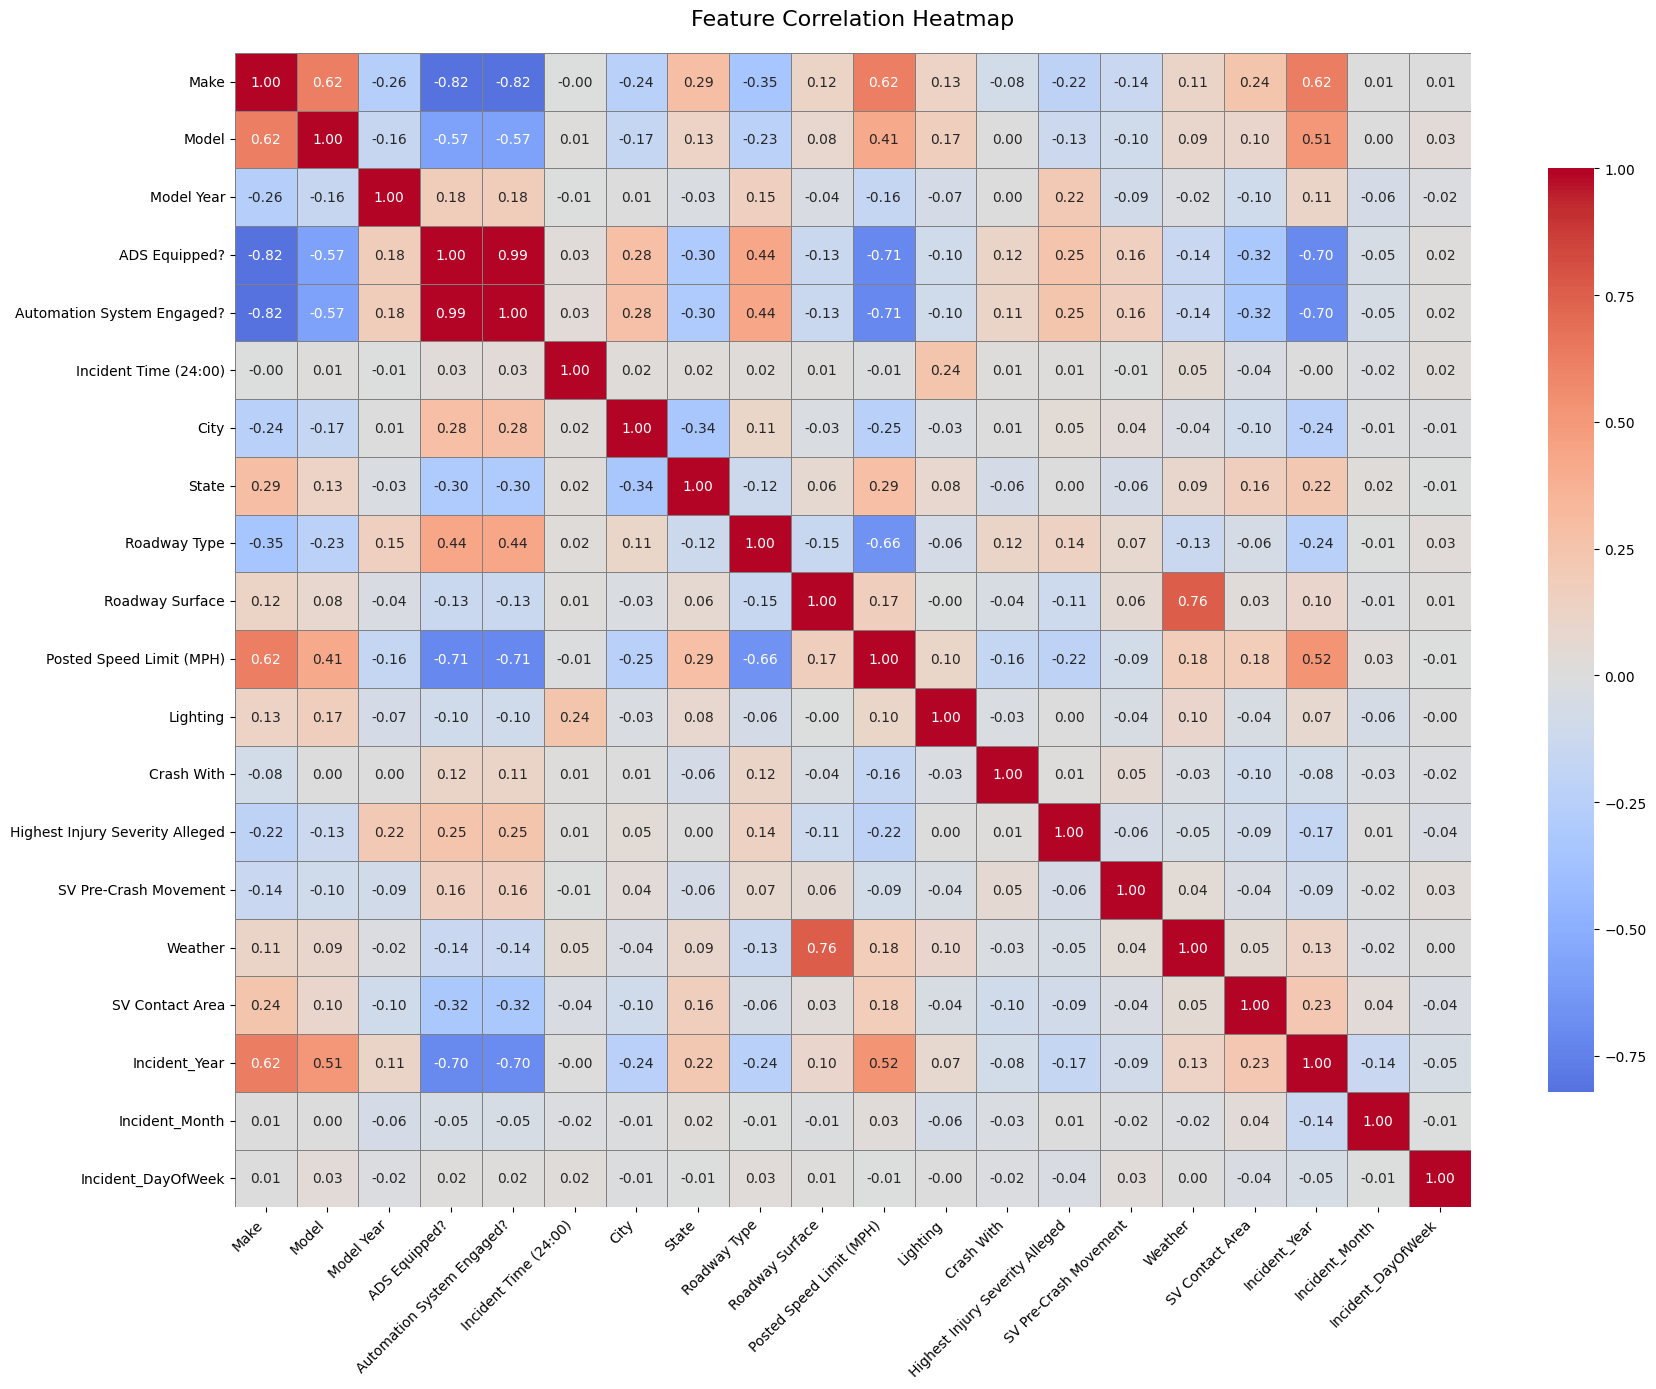

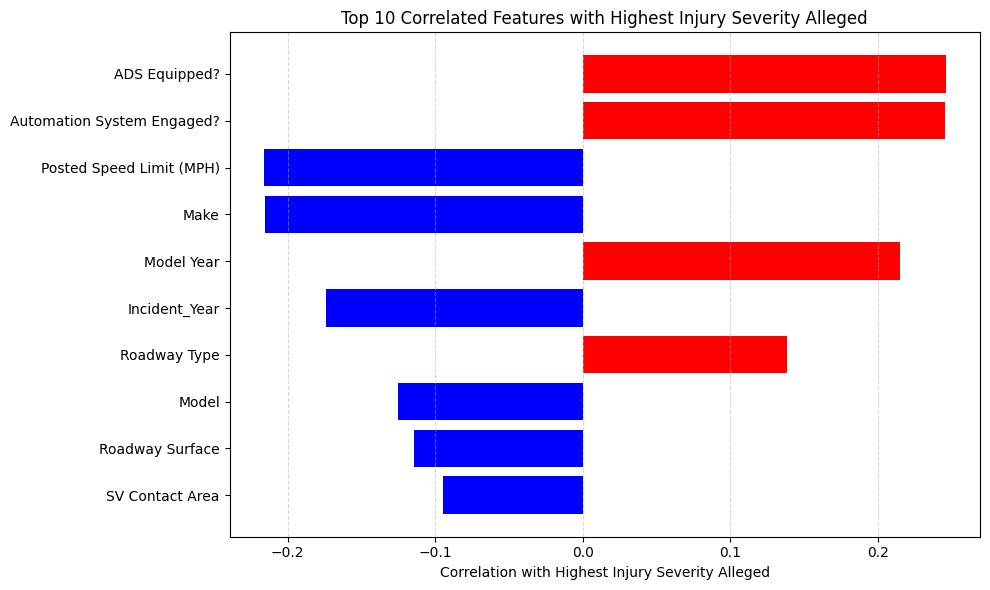


Top 10 Features with Highest Absolute Correlation to 'Highest Injury Severity Alleged':

ADS Equipped?                 0.245979
Automation System Engaged?    0.245132
Posted Speed Limit (MPH)     -0.216305
Make                         -0.215623
Model Year                    0.215078
Incident_Year                -0.173924
Roadway Type                  0.138621
Model                        -0.125326
Roadway Surface              -0.114734
SV Contact Area              -0.094822
Name: Highest Injury Severity Alleged, dtype: float64

Number of rows used in correlation calculation: 4032


ADS Equipped?                 0.245979
Automation System Engaged?    0.245132
Posted Speed Limit (MPH)     -0.216305
Make                         -0.215623
Model Year                    0.215078
Incident_Year                -0.173924
Roadway Type                  0.138621
Model                        -0.125326
Roadway Surface              -0.114734
SV Contact Area              -0.094822
Name: Highest Injury Severity Alleged, dtype: float64

In [23]:
drop_cols_us = ['Country','Report Version','Report ID']
plot_heatmap_with_severity_corr(
    encoded_df=US_encoded_df,
    df_name="US",
    index_cols=drop_cols_us,
    figsize=(18, 14), 
    annot=True,        # Show correlation values   
)

**UK Heatmap**
- incident year is in report id hence corelated

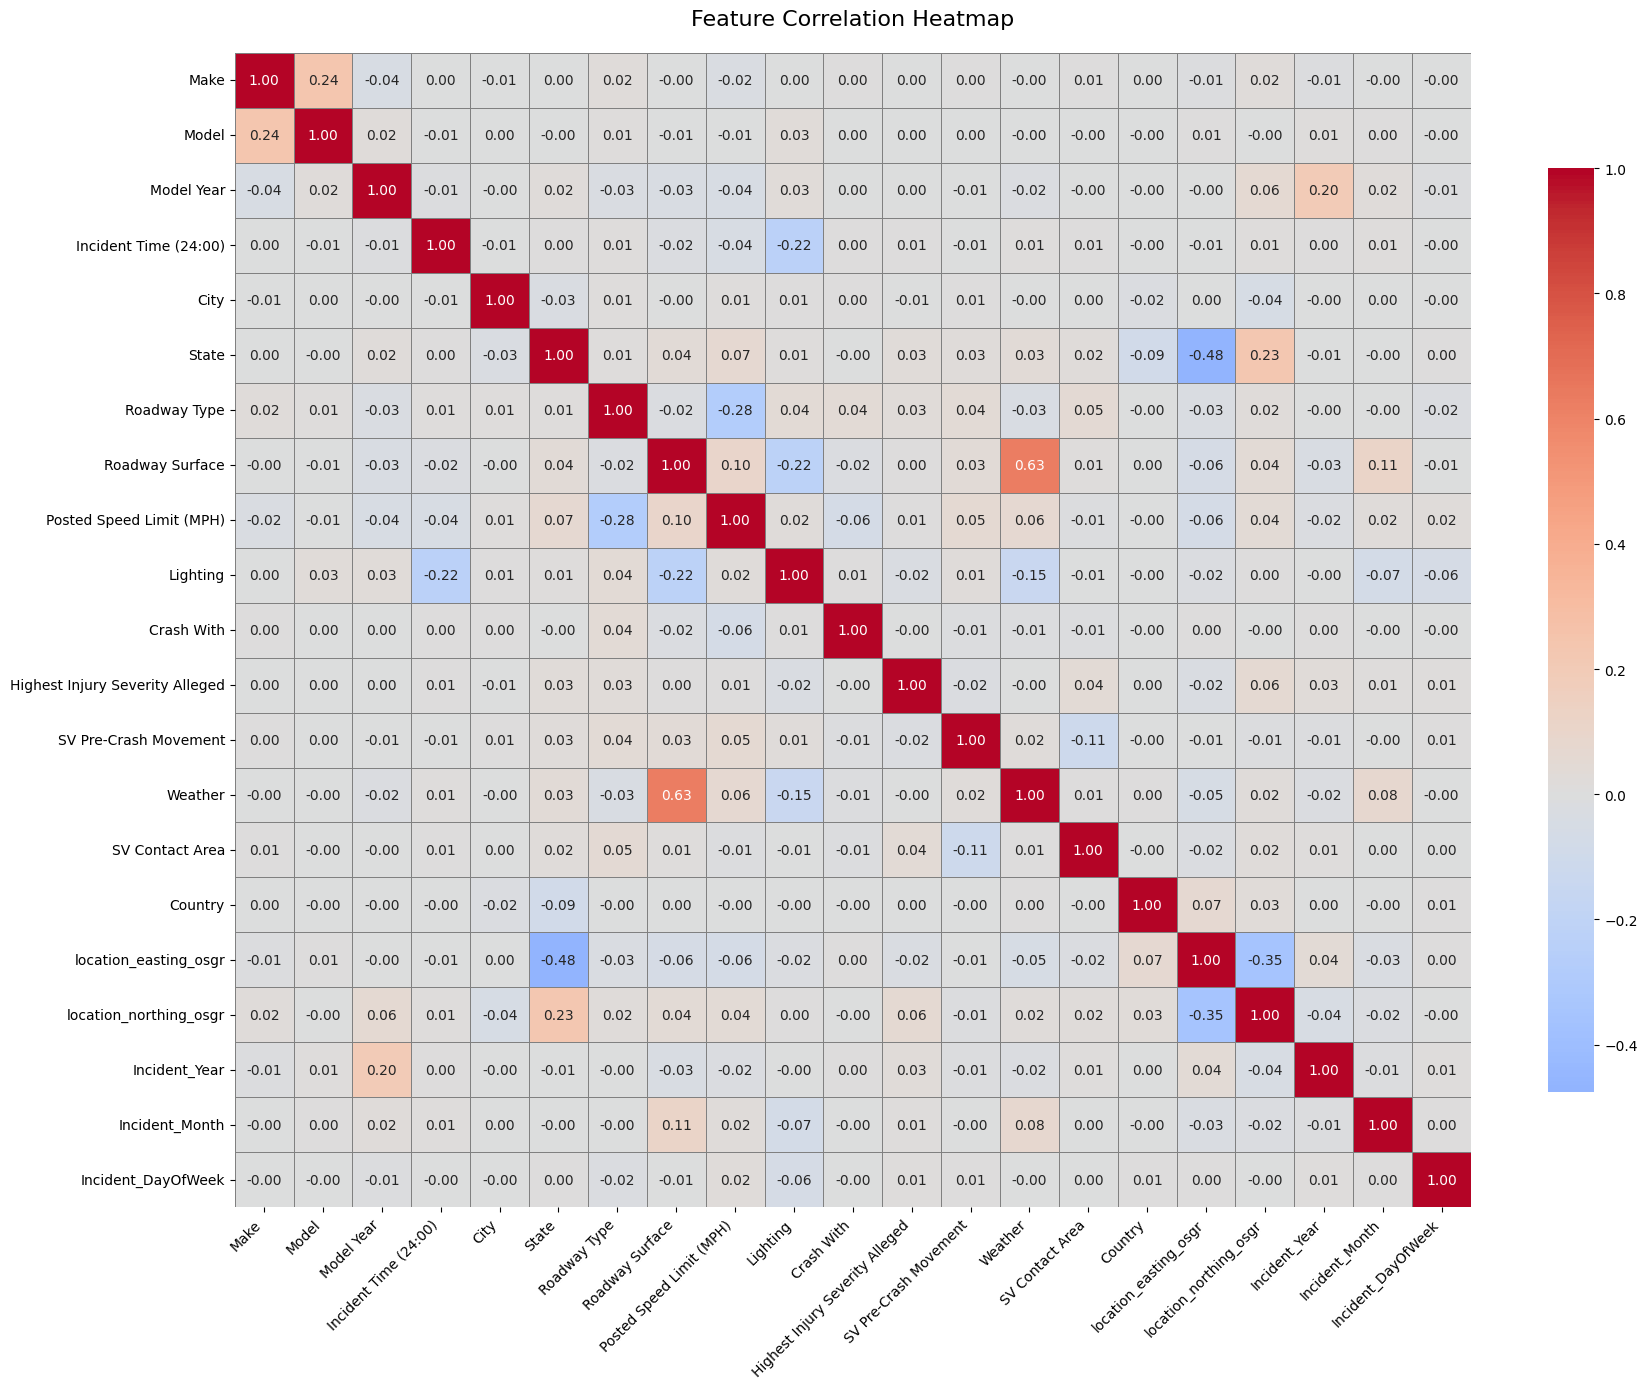

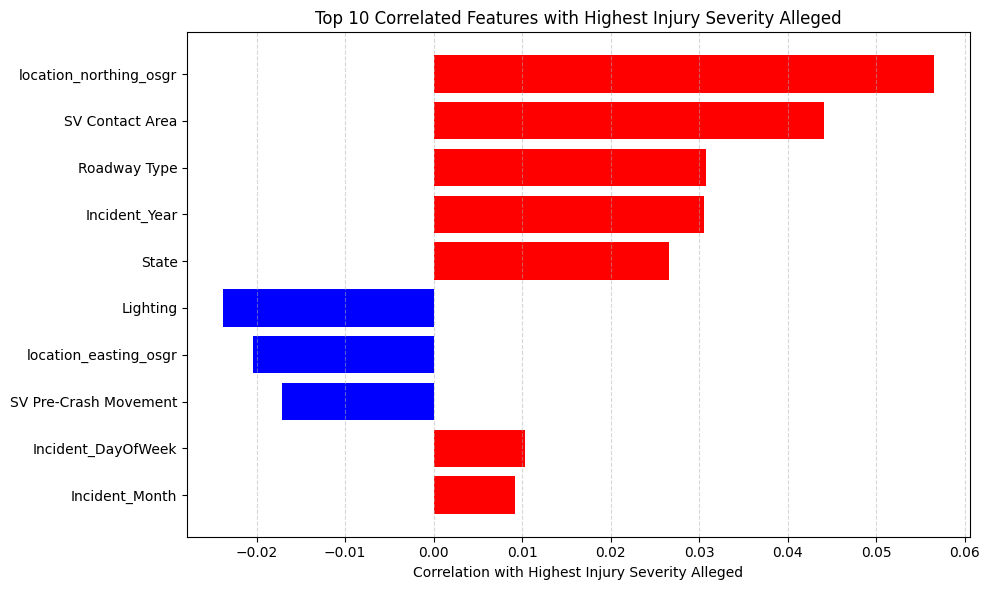


Top 10 Features with Highest Absolute Correlation to 'Highest Injury Severity Alleged':

location_northing_osgr    0.056545
SV Contact Area           0.044122
Roadway Type              0.030824
Incident_Year             0.030526
State                     0.026601
Lighting                 -0.023817
location_easting_osgr    -0.020412
SV Pre-Crash Movement    -0.017140
Incident_DayOfWeek        0.010381
Incident_Month            0.009147
Name: Highest Injury Severity Alleged, dtype: float64

Number of rows used in correlation calculation: 229782


location_northing_osgr    0.056545
SV Contact Area           0.044122
Roadway Type              0.030824
Incident_Year             0.030526
State                     0.026601
Lighting                 -0.023817
location_easting_osgr    -0.020412
SV Pre-Crash Movement    -0.017140
Incident_DayOfWeek        0.010381
Incident_Month            0.009147
Name: Highest Injury Severity Alleged, dtype: float64

In [24]:
drop_cols_uk = ['ADS Equipped?','Automation System Engaged?','Report Version','Report ID']
plot_heatmap_with_severity_corr(
    encoded_df=UK_encoded_df,
    df_name="UK",
    index_cols=drop_cols_uk,
    figsize=(18, 14),  
    annot=True,        # Show correlation values
)

## **<span style="color:black;">Section 6: Saving Encoded and Scaled Datasets</span>**

**Save the raw imputed dataframe**

In [25]:
# the imputed
US_final_imputed.to_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_data.csv', index=False)

**Save the encoded and scaled dataframe**

In [26]:
# encoded and scaled
US_encoded_df.to_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_scaled_data.csv', index=False)
UK_encoded_df.to_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK_scaled_data.csv', index=False)